In [1]:
import os
import yaml
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
FILE_PATH = "data/housing.csv"
CALIFORNIA_PATH = "images/california.png"

In [3]:
df = pd.read_csv(FILE_PATH) 
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
#file check, attribute check
missing_num = len(df) - len(df.dropna())
missing_ratio = missing_num / len(df)
missing_ratio = np.round(missing_ratio * 100,3)
print(f"{missing_ratio}% of the dataset ({missing_num} points) are missing data!")    

1.003% of the dataset (207 points) are missing data!


In [5]:
#show missing data
df.loc[df.isnull().sum(axis=1) == 1]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN


In [6]:
#show NaN values
df.isnull().sum(axis=0)

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
df = df.dropna()
df = df.reset_index(drop=True)

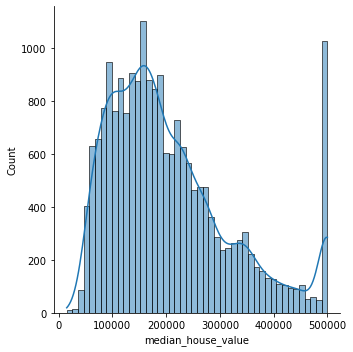

In [8]:
#show target variable
sns.displot(data=df, x="median_house_value", kde=True)

In [9]:
description = df.describe()
description

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [10]:
#categorize data and prepare data split
bins = [0] + list(description["median_house_value"][
    ["25%", "50%", "75%"]
].astype(int)) + [np.inf]
print(bins)

[0, 119500, 179700, 264700, inf]


<AxesSubplot:xlabel='house_cat', ylabel='count'>

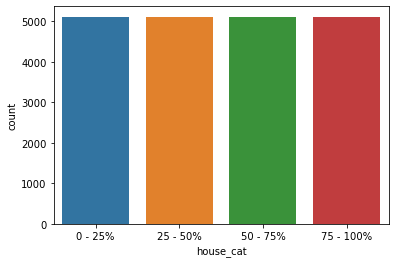

In [11]:
#categories
df["house_cat"] = pd.cut(
    df["median_house_value"],
    bins=bins,
    labels=["0 - 25%", "25 - 50%", "50 - 75%", "75 - 100%"]
)

sns.countplot(data=df, x="house_cat")

In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
for train_index, test_index in split.split(df, df["house_cat"]):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]    

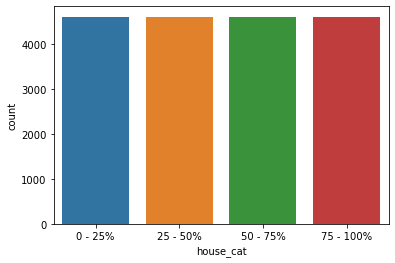

In [13]:
sns.countplot(data=df_train, x="house_cat");

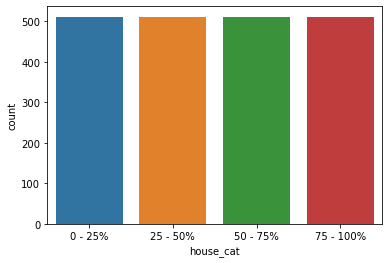

In [14]:
sns.countplot(data=df_test, x="house_cat");

In [15]:
df_train = df_train.drop("house_cat", axis=1)
df_test = df_test.drop("house_cat", axis=1)

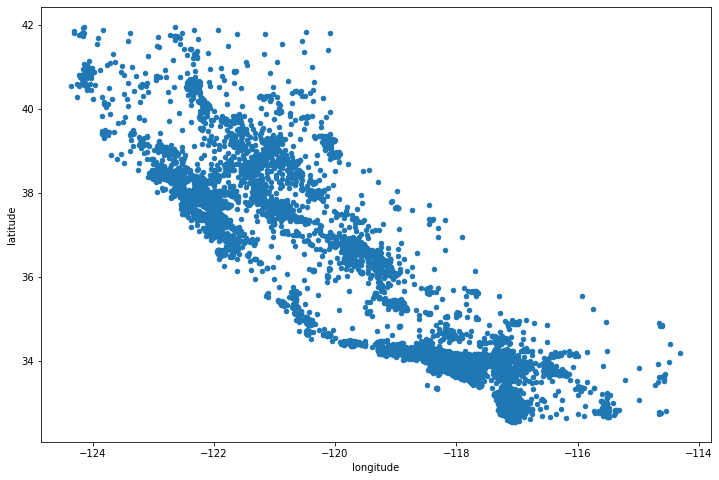

In [16]:
# looking at longitude and latitude values
df_train.plot(kind="scatter", x="longitude", y="latitude", figsize=(12,8));

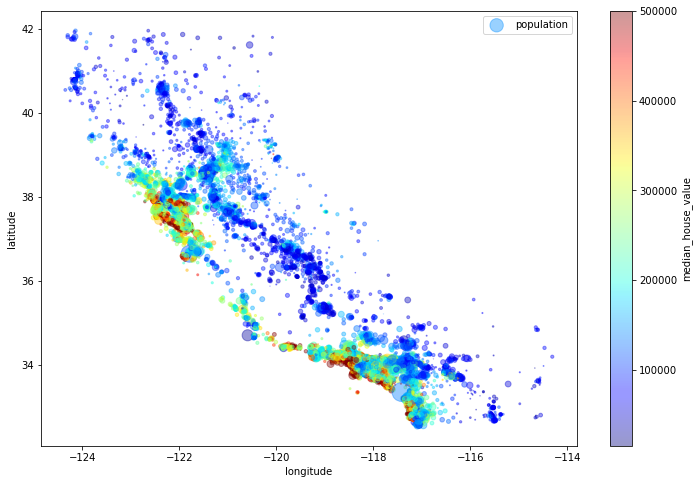

In [17]:
# adding population and median_house_value to plot
df_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
    s=df_train["population"]/100, label="population", figsize=(12, 8), c="median_house_value", 
    cmap=plt.get_cmap("jet"), colorbar=True, sharex=False
)
plt.legend();


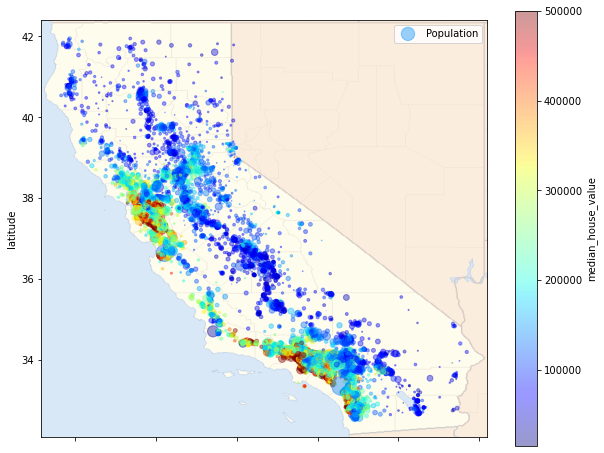

In [18]:
from helper_functions import plot_df_on_california
plot_df_on_california(df_train, CALIFORNIA_PATH)

In [19]:
ocean_proximity_value_counts = df_train["ocean_proximity"].value_counts()
ocean_proximity_value_counts

<1H OCEAN     8103
INLAND        5848
NEAR OCEAN    2397
NEAR BAY      2036
ISLAND           5
Name: ocean_proximity, dtype: int64

In [20]:
median_house_values_by_proximity = df_train.groupby("ocean_proximity")["median_house_value"].median()
median_house_values_by_proximity

ocean_proximity
<1H OCEAN     215700.0
INLAND        108550.0
ISLAND        414700.0
NEAR BAY      233150.0
NEAR OCEAN    228200.0
Name: median_house_value, dtype: float64

In [21]:
def filter_df_by_proximity(df, proximity):
    return df.loc[df["ocean_proximity"] == proximity]

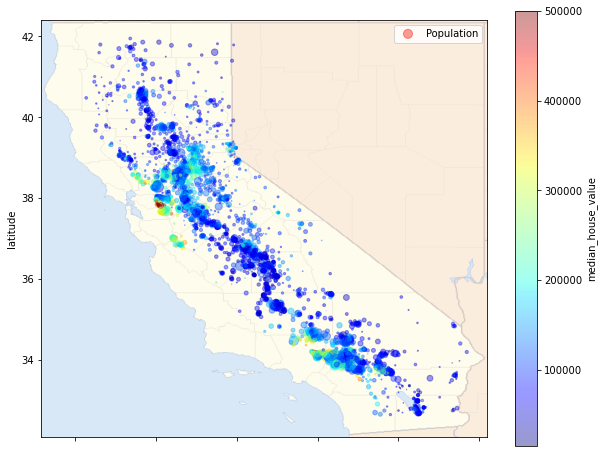

In [22]:
plot_df_on_california(filter_df_by_proximity(df_train, "INLAND"), CALIFORNIA_PATH)

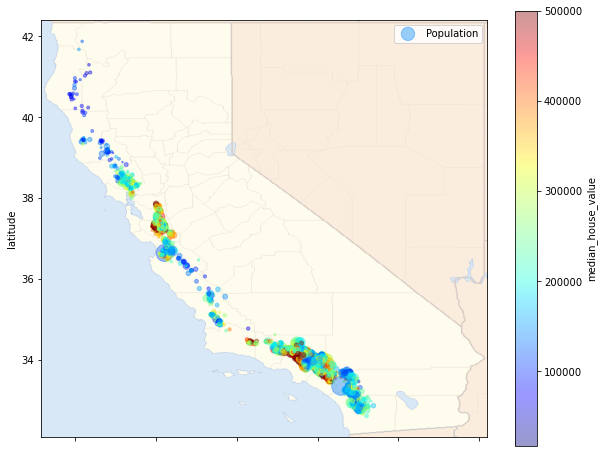

In [23]:
plot_df_on_california(filter_df_by_proximity(df_train, "<1H OCEAN"), CALIFORNIA_PATH)

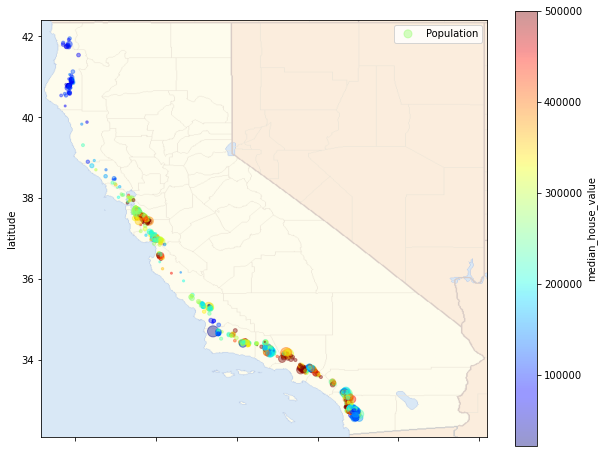

In [24]:
plot_df_on_california(filter_df_by_proximity(df_train, "NEAR OCEAN"), CALIFORNIA_PATH)

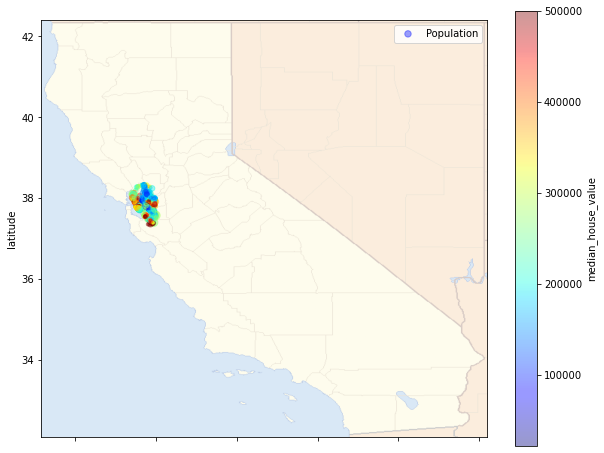

In [25]:
plot_df_on_california(filter_df_by_proximity(df_train, "NEAR BAY"), CALIFORNIA_PATH)

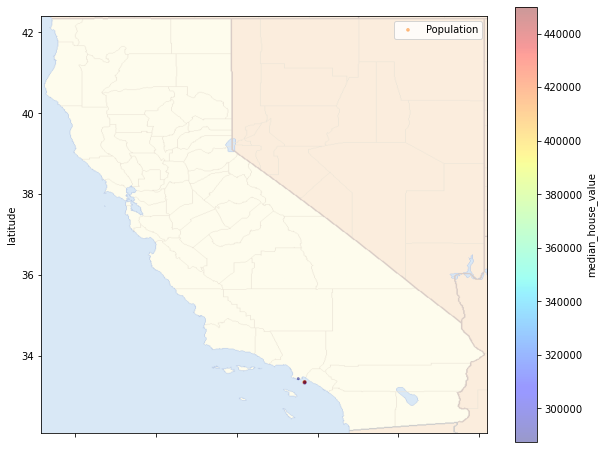

In [26]:
plot_df_on_california(filter_df_by_proximity(df_train, "ISLAND"), CALIFORNIA_PATH)

In [27]:
# ISLAND has no consisten data
df_train = df_train.drop(filter_df_by_proximity(df_train, "ISLAND").index)
df_test = df_test.drop(filter_df_by_proximity(df_test, "ISLAND").index)

In [28]:
# prognose without ML
def predict_by_ocean_proximity(df, median_house_values_by_proximity):
    df["ocean_proximity_prediction"] = df["ocean_proximity"].apply(
        lambda x: median_house_values_by_proximity[x]
    )
    return df

In [29]:
#baseline
df_train = predict_by_ocean_proximity(df_train, median_house_values_by_proximity)
df_test = predict_by_ocean_proximity(df_test, median_house_values_by_proximity)
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_prediction
11242,-117.93,33.74,15.0,1206.0,282.0,677.0,270.0,3.9219,142600.0,<1H OCEAN,215700.0
987,-121.72,37.70,17.0,1671.0,352.0,729.0,252.0,6.1023,450000.0,INLAND,108550.0
8052,-118.11,33.83,36.0,1462.0,233.0,664.0,220.0,5.1171,225300.0,<1H OCEAN,215700.0
6699,-118.15,34.11,52.0,1746.0,330.0,704.0,306.0,3.7895,364800.0,<1H OCEAN,215700.0
253,-122.21,37.77,52.0,745.0,153.0,473.0,149.0,2.6765,88800.0,NEAR BAY,233150.0


In [30]:
# correlation of attributes -> pearson coefficient of correlation
df_train.corr()["median_house_value"].abs().sort_values(ascending=False)

median_house_value            1.000000
median_income                 0.687099
ocean_proximity_prediction    0.487305
latitude                      0.146662
total_rooms                   0.135776
housing_median_age            0.101194
households                    0.068897
total_bedrooms                0.053297
longitude                     0.042352
population                    0.020252
Name: median_house_value, dtype: float64

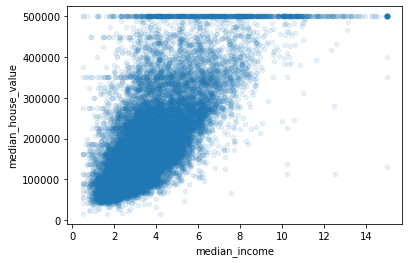

In [31]:
# the better the income, the better the residential area
df_train.plot(
    kind="scatter",
    x="median_income",
    y="median_house_value",
    alpha=0.1
);

In [32]:
# some more interesting attributes based on correlation
def engineer_features(df):
    df["ratio_bedrooms"] = df["total_bedrooms"] / df["total_rooms"]
    df["people_per_household"] = df["population"] / df["households"]
    return df

In [33]:
df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

In [34]:
df_train.corr()["median_house_value"].abs().sort_values(ascending=False)

median_house_value            1.000000
median_income                 0.687099
ocean_proximity_prediction    0.487305
ratio_bedrooms                0.253775
latitude                      0.146662
total_rooms                   0.135776
housing_median_age            0.101194
households                    0.068897
total_bedrooms                0.053297
longitude                     0.042352
people_per_household          0.020838
population                    0.020252
Name: median_house_value, dtype: float64

In [35]:
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_prediction,ratio_bedrooms,people_per_household
11242,-117.93,33.74,15.0,1206.0,282.0,677.0,270.0,3.9219,142600.0,<1H OCEAN,215700.0,0.233831,2.507407
987,-121.72,37.70,17.0,1671.0,352.0,729.0,252.0,6.1023,450000.0,INLAND,108550.0,0.210652,2.892857
8052,-118.11,33.83,36.0,1462.0,233.0,664.0,220.0,5.1171,225300.0,<1H OCEAN,215700.0,0.159371,3.018182
6699,-118.15,34.11,52.0,1746.0,330.0,704.0,306.0,3.7895,364800.0,<1H OCEAN,215700.0,0.189003,2.300654
253,-122.21,37.77,52.0,745.0,153.0,473.0,149.0,2.6765,88800.0,NEAR BAY,233150.0,0.205369,3.174497


In [36]:
df_train_ml = pd.get_dummies(df_train) #One-Hot Encoding
df_test_ml = pd.get_dummies(df_test)

In [37]:
df_train_ml.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_prediction,ratio_bedrooms,people_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
11242,-117.93,33.74,15.0,1206.0,282.0,677.0,270.0,3.9219,142600.0,215700.0,0.233831,2.507407,1,0,0,0
987,-121.72,37.70,17.0,1671.0,352.0,729.0,252.0,6.1023,450000.0,108550.0,0.210652,2.892857,0,1,0,0
8052,-118.11,33.83,36.0,1462.0,233.0,664.0,220.0,5.1171,225300.0,215700.0,0.159371,3.018182,1,0,0,0
6699,-118.15,34.11,52.0,1746.0,330.0,704.0,306.0,3.7895,364800.0,215700.0,0.189003,2.300654,1,0,0,0
253,-122.21,37.77,52.0,745.0,153.0,473.0,149.0,2.6765,88800.0,233150.0,0.205369,3.174497,0,0,1,0


In [39]:
def get_features_and_targets(df):
    x = df.drop(["median_house_value"], axis=1).values
    y = np.stack(df["median_house_value"])
    return x,y

In [40]:
x_train, y_train = get_features_and_targets(df_train_ml)
x_test, y_test = get_features_and_targets(df_test_ml)

In [42]:
# build ki model with linear regression 
clf = LinearRegression()
clf.fit(x_train, y_train)

LinearRegression()

In [43]:
predictions = clf.predict(x_test)

In [49]:
print("Prediction\t|True")
print("-"*30)
for idx, (pred, annotation) in enumerate(zip(predictions, y_test)):
    if idx == 10:
        break
    pred = int(pred)
    annotation = int(annotation)
    print(f"{pred}\t\t|{annotation}")

Prediction	|True
------------------------------
259414		|240500
259642		|345500
215271		|154300
169631		|146900
233583		|240200
278476		|293000
177266		|142400
232861		|224700
373261		|352100
178363		|146900


In [50]:
mae = metrics.mean_absolute_error(y_test, predictions)
mae_ratio = metrics.mean_absolute_percentage_error(y_test, predictions)
r2_score = metrics.r2_score(y_test, predictions)

In [51]:
print(f"R^2 value {np.round(r2_score * 100)}%")

R^2 value 67.0%


In [ ]:
df_test.iloc[0]
x_test[0]
single_pred = clf.predict([X_test[0]])[0]
print(f"Prognose {single_pred}.")
print(f"Real {y_test[0]}.")

